this scrip based on feature4.ipynb

train on day8, validate on day9 with/wo ip<126420

0. train: day8, val: day9 
1. train: day8 ,val: day9 ip<126420
    - local: 0.966159
    - LB   : 0.9789
2. train: day8 + day9 (first 10 milion) ip<126420, val:day9 others ip<126420 
    - local: `0.9653`
    - LB   : `0.9729`
    
3. train: day8 + day9 (first 10 milion), val: day9 others ip<126420
    - local: `0.9655`
4. train: day8 + day9 (first 30 milion), val: day9 others & ip<126420
    - local: `0.9624`

In [1]:
import pandas as pd 
import gc
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import time

In [2]:
with pd.HDFStore('../input/feat/feat4_trn_day8_val_day9.h5') as store:
    print(store.keys())
    train_df = store['train_df']
    val_df = store['valid_df']
    test_df = store['test_df']

['/test_df', '/train_df', '/valid_df']


In [3]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(62360949, 24)
shape of val  :(62832642, 24)
shape of test :(18790469, 24)


In [4]:
train_df.is_attributed.value_counts()

0.0    62209584
1.0      151365
Name: is_attributed, dtype: int64

In [5]:
val_df.is_attributed.value_counts()

0.0    62679243
1.0      153399
Name: is_attributed, dtype: int64

In [4]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

In [5]:
train_df = train_df.append(val_df.head(30000000))
val_df = val_df.iloc[30000000:]
val_df = val_df[val_df.ip< 126420]

In [6]:
gc.collect()

27

In [8]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(92360949, 24)
shape of val  :(26920995, 24)
shape of test :(18790469, 24)


In [9]:
train_df.columns

Index(['app', 'channel', 'click_id', 'click_time', 'day', 'device', 'hour',
       'ip', 'is_attributed', 'os', 'channel_nunique_ip',
       'app_cumcnt_ip_device_os', 'hour_nunique_ip_day', 'app_nunique_ip',
       'app_nunique_channel', 'app_nunique_ip_device_os', 'channel_cnt_ip_app',
       'channel_cnt_ip_day_hour', 'next_click_dt',
       'ip_app_os_device_mean_target', 'ip_mean_target', 'app_mean_target',
       'channel_mean_target', 'device_mean_target'],
      dtype='object')

In [10]:
# print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.20,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200 # because training data is extremely unbalanced 
}

target = 'is_attributed'
categorical = ['app', 'device', 'os', 'channel', 'hour','day']

predictors = list(val_df.columns)
remove_col = ['click_id','click_time','is_attributed','ip_app_os_device_mean_target']
predictors = [e for e in predictors if e not in remove_col]

In [11]:
print('numbers of features', len(predictors))
predictors

numbers of features 19


['app',
 'channel',
 'device',
 'hour',
 'ip',
 'os',
 'channel_nunique_ip',
 'app_cumcnt_ip_device_os',
 'hour_nunique_ip_day',
 'app_nunique_ip',
 'app_nunique_channel',
 'app_nunique_ip_device_os',
 'channel_cnt_ip_app',
 'channel_cnt_ip_day_hour',
 'next_click_dt',
 'ip_mean_target',
 'app_mean_target',
 'channel_mean_target',
 'device_mean_target']

In [12]:
(bst,best_iteration) = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1000,  
                        categorical_features=categorical)

preparing validation datasets


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.935723
[20]	valid's auc: 0.944579
[30]	valid's auc: 0.951248
[40]	valid's auc: 0.955348
[50]	valid's auc: 0.957784
[60]	valid's auc: 0.959009
[70]	valid's auc: 0.960111
[80]	valid's auc: 0.960922
[90]	valid's auc: 0.96135
[100]	valid's auc: 0.961863
[110]	valid's auc: 0.961972
[120]	valid's auc: 0.962206
[130]	valid's auc: 0.962465
[140]	valid's auc: 0.962261
[150]	valid's auc: 0.962228
[160]	valid's auc: 0.962358
Early stopping, best iteration is:
[130]	valid's auc: 0.962465

Model Report
bst1.best_iteration:  130
auc: 0.962465071905


# explore

In [13]:
train_df.is_attributed.value_counts()

0.0    92139497
1.0      221452
Name: is_attributed, dtype: int64

In [14]:
val_df.is_attributed.value_counts()

0.0    26890736
1.0       30259
Name: is_attributed, dtype: int64

# Sub 
 

Plot feature importances...


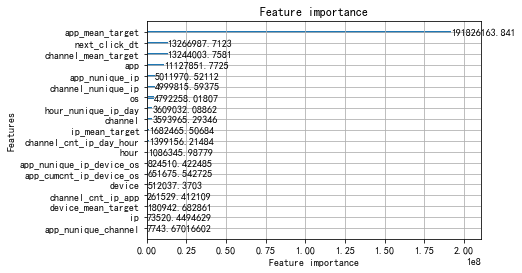

In [15]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100,importance_type='gain')

In [16]:
feat_imp = pd.DataFrame({'f':bst.feature_name(),
                         'split':bst.feature_importance(importance_type='split'),
                         'gain':bst.feature_importance(importance_type='gain')}).sort_values(by='split',ascending=False)
feat_imp.to_csv('../find/feat_impact04_5.csv',index=False)

In [17]:
bst.save_model('../output/model/lgb_val_9624_on_day9.txt')

In [18]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype(int)

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
print('complete')    

Predicting...
complete


In [19]:
sub.dtypes

click_id           int32
is_attributed    float64
dtype: object

In [20]:
sub.head()

,click_id,is_attributed
0,0,0.260624
1,1,0.047724
2,2,0.004745
3,3,0.055811
4,4,0.027745


In [21]:
sub['click_id'] = sub.click_id.astype('uint32')
sub['is_attributed'] = sub.is_attributed.astype('float16')

In [22]:
print('writing...')
fileno = 7
sub.to_csv('../output/sub_it{}.csv.gz'.format(fileno),index=False,compression='gzip')
print('finished')

writing...
finished


_____